# Analysis of Koenig et al. Data

Analysis of expression and binding data from Koenig et al using various models.

In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from netam import pretrained, molevol
from netam.framework import load_crepe, trimmed_shm_model_outputs_of_crepe
from netam.sequences import AA_STR_SORTED, nt_idx_tensor_of_str
from dnsmex.ablang_wrapper import AbLangWrapper
from dnsmex.esm_wrapper import esm2_wrapper_of_size
from dnsmex.dasm_viz import dms_style_heatmap
from dnsmex.local import localify
from dnsmex.koenig_helper import (
    KoenigDataset, plot_variant_comparison,
    assign_wt, df_of_arr, trim_df, process_model_output, evaluate_paired_model
)
from dnsmex import perplexity

figures_dir = localify("FIGURES_DIR")
os.makedirs("_output", exist_ok=True)

## Binding Data

(<Figure size 1400x1000 with 4 Axes>,
 (<Axes: title={'center': 'Heavy Chain'}, xlabel='site', ylabel='aa'>,
  <Axes: title={'center': 'Light Chain'}, xlabel='site', ylabel='aa'>))

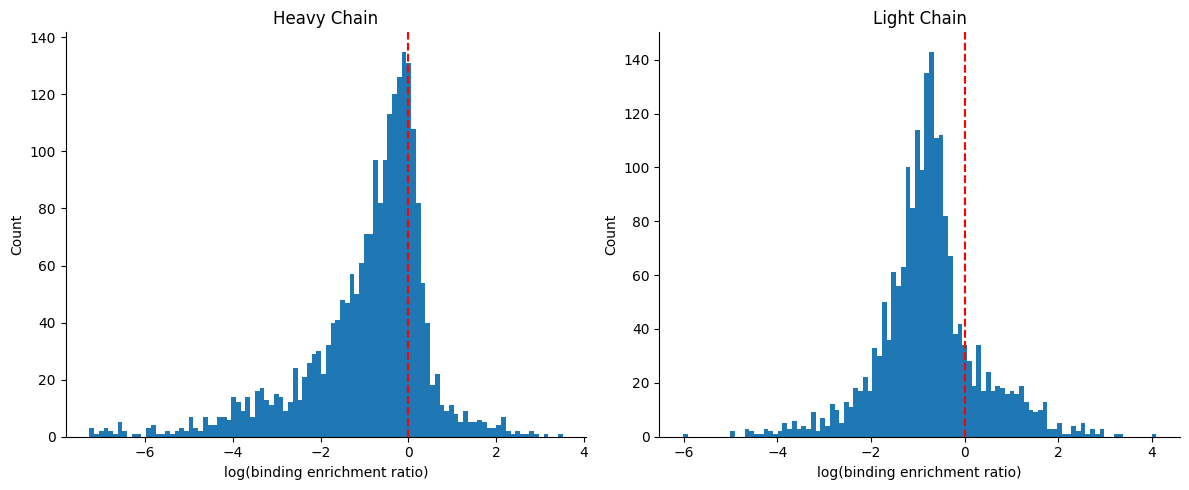

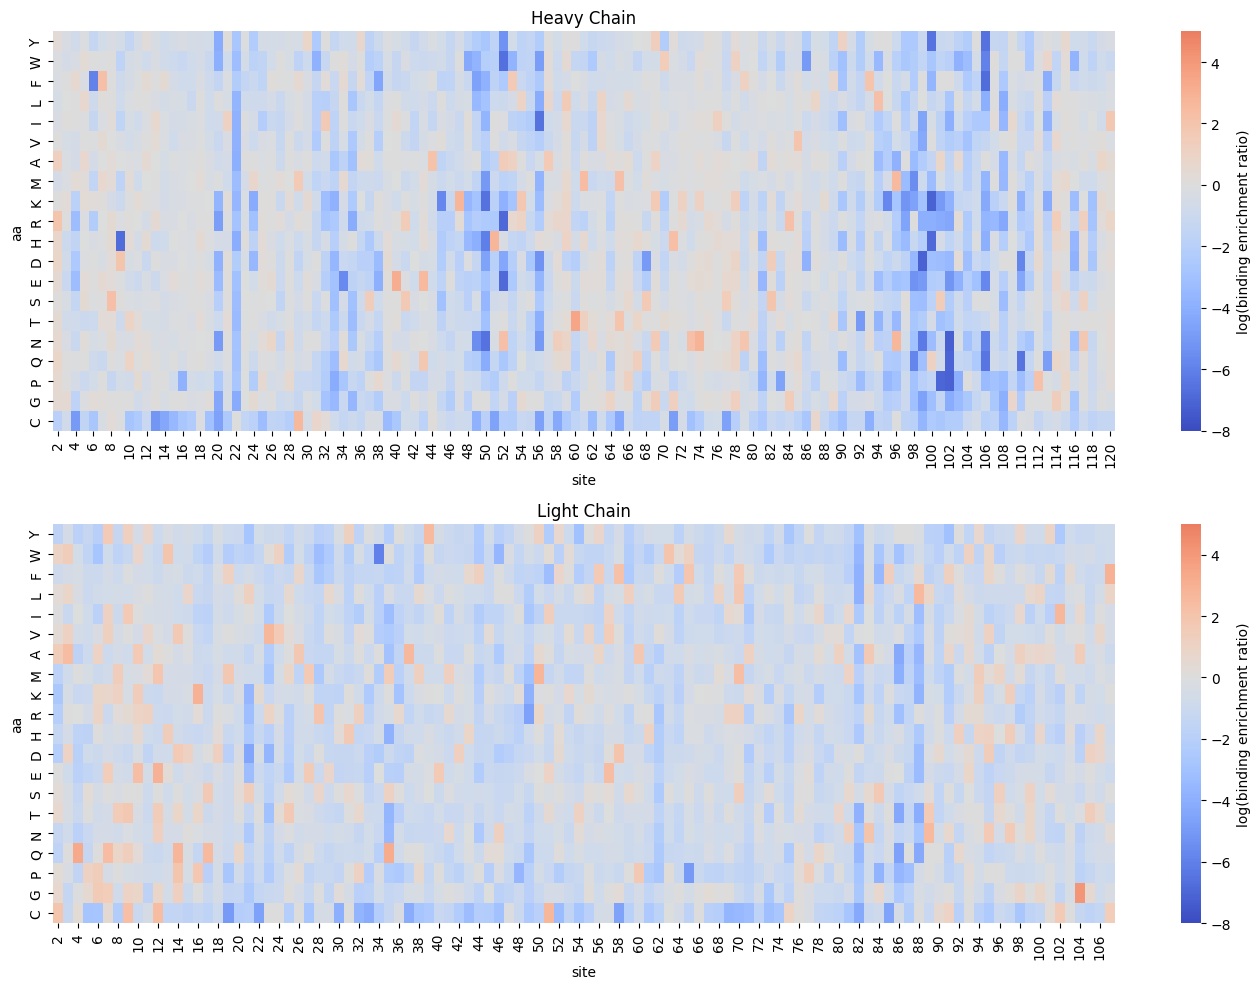

In [2]:
binding_dataset = KoenigDataset(
    localify("DATA_DIR/FLAb/data/binding/Koenig2017_g6_Kd.csv"),
    fitness_column="fitness",
    fitness_label="binding enrichment ratio",
    log_transform=True,
)

binding_dataset.plot_fitness_histograms()
binding_dataset.plot_heatmaps()

## Expression Data

(<Figure size 1400x1000 with 4 Axes>,
 (<Axes: title={'center': 'Heavy Chain'}, xlabel='site', ylabel='aa'>,
  <Axes: title={'center': 'Light Chain'}, xlabel='site', ylabel='aa'>))

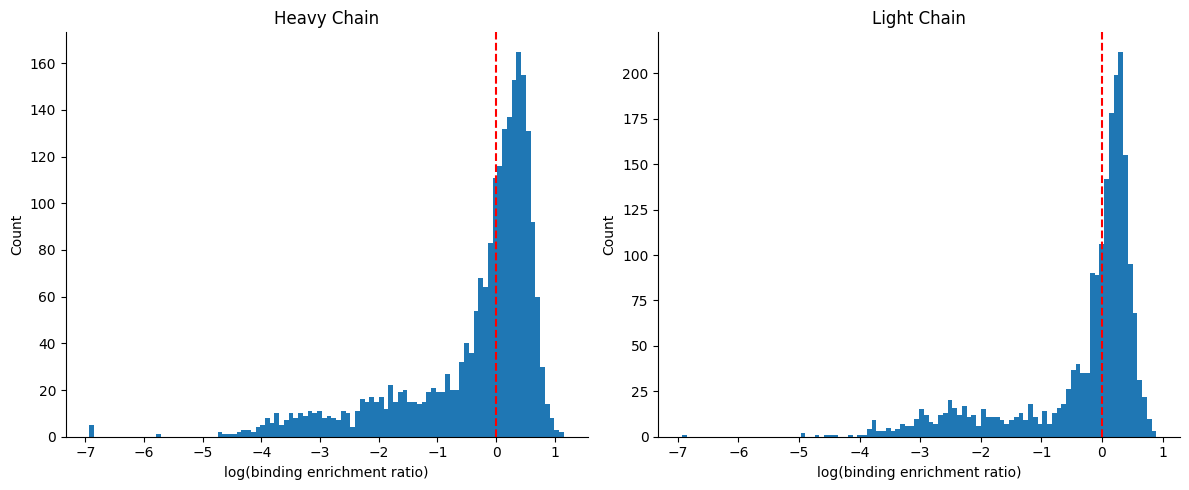

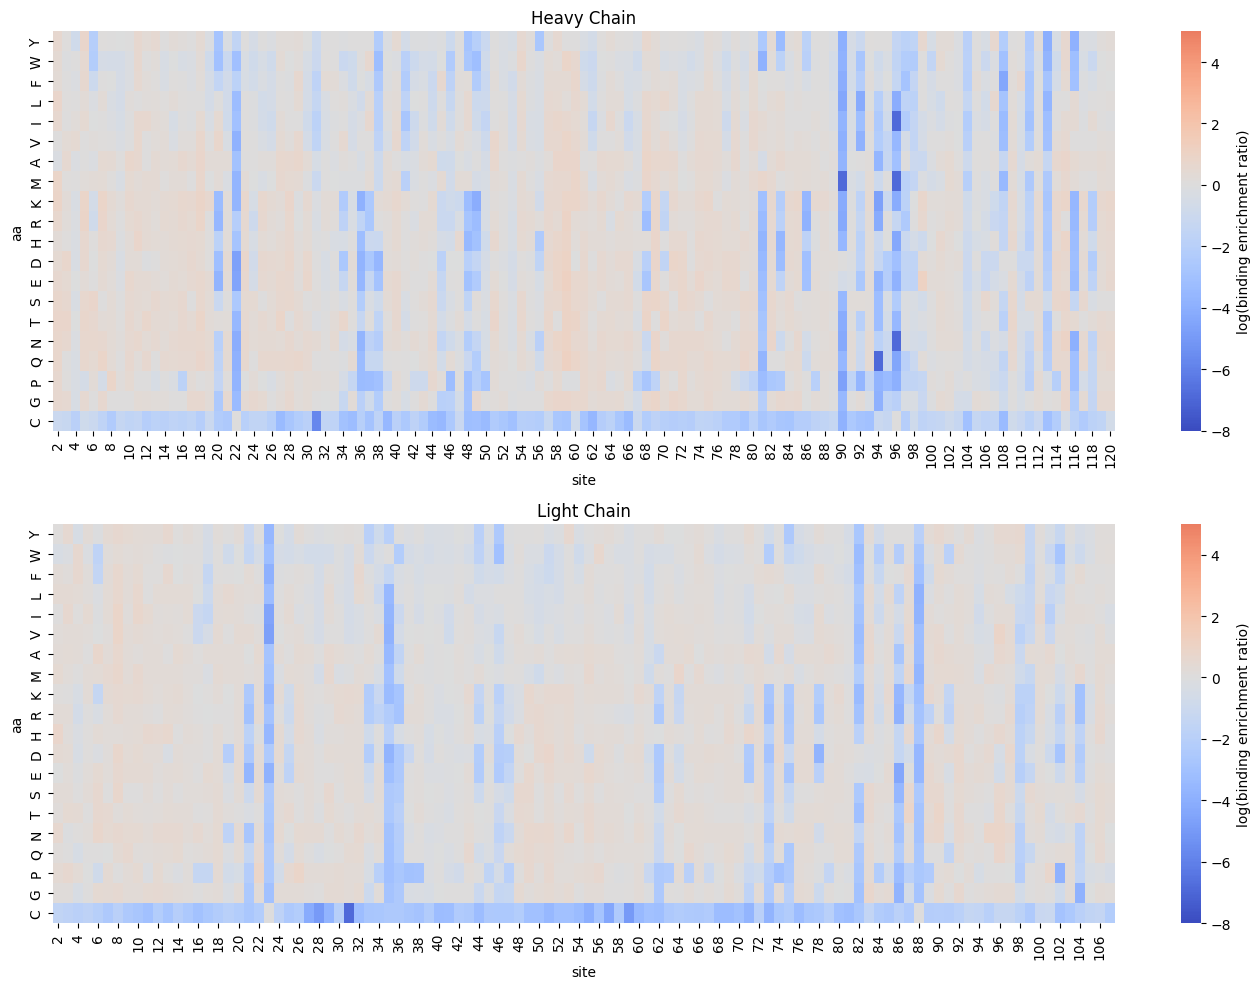

In [3]:
expr_dataset = KoenigDataset(
    localify("DATA_DIR/FLAb/data/expression/Koenig2017_g6_er.csv"), 
    fitness_column="fitness",
    fitness_label="binding enrichment ratio",
    log_transform=True,
    )

expr_dataset.plot_fitness_histograms()
expr_dataset.plot_heatmaps()

In [4]:
heavy_wt = expr_dataset.heavy_consensus
light_wt = expr_dataset.light_consensus

heavy_wt, light_wt

len(heavy_wt), len(light_wt)

(120, 108)

## Load Models

In [5]:
def dfs_of_logits(logits, wt_seq):
    """Convert logits array into logits and perplexity dataframes.
    
    Args:
        logits: Tensor or array of model logits
        wt_seq: Wild-type sequence for perplexity calculation
        
    Returns:
        tuple: (logits_df, perplexity_df) of trimmed dataframes
    """
    logits_df = df_of_arr(logits).copy()
    assign_wt(logits_df, wt_seq, np.nan)
    logits_df = trim_df(logits_df)
    
    perplexity_vals = perplexity.per_variant_pseudo_perplexity(torch.Tensor(logits), wt_seq)
    perplexity_df = df_of_arr(perplexity_vals)
    assign_wt(perplexity_df, wt_seq, np.nan)
    perplexity_df = trim_df(perplexity_df)

    return logits_df, perplexity_df

In [6]:
def dfs_of_logits(logits, wt_seq, chain="heavy"):
    """Convert logits array into logits and perplexity dataframes.
    
    Args:
        logits: Tensor or array of model logits
        wt_seq: Wild-type sequence for perplexity calculation
        chain: "heavy" or "light" - determines trimming behavior
        
    Returns:
        tuple: (logits_df, perplexity_df) of trimmed dataframes
    """
    logits_df = df_of_arr(logits).copy()
    assign_wt(logits_df, wt_seq, np.nan)
    logits_df = trim_df(logits_df, chain=chain)
    
    perplexity_vals = perplexity.per_variant_pseudo_perplexity(torch.Tensor(logits), wt_seq)
    perplexity_df = df_of_arr(perplexity_vals)
    assign_wt(perplexity_df, wt_seq, np.nan)
    perplexity_df = trim_df(perplexity_df, chain=chain)

    return logits_df, perplexity_df

In [7]:
# Load DASM model
crepe = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_4m-v1tangCC+v1vanwinkleheavyTrainCC+v1jaffePairedCC+v1vanwinklelightTrainCC1m-joint"))
neutral_crepe = pretrained.load(crepe.model.hyperparameters["neutral_model_name"])

# Use the paired model to get predictions for both chains
dasm_predictions = evaluate_paired_model(crepe, expr_dataset.heavy_consensus, expr_dataset.light_consensus)

# Process heavy chain predictions
log_dasm_heavy_df = process_model_output(dasm_predictions['heavy'], heavy_wt, log_transform=True, chain="heavy")

# Process light chain predictions
log_dasm_light_df = process_model_output(dasm_predictions['light'], light_wt, log_transform=True, chain="light")

Loading model ThriftyHumV0.2-59
Using cached models: /Users/matsen/re/netam/netam/_pretrained/thrifty-0.2.0.zip


In [8]:
# Load AbLang model 
ablang_wrapper = AbLangWrapper()
ablang_logits = ablang_wrapper.masked_logits(expr_dataset.heavy_consensus, expr_dataset.light_consensus)

# Extract heavy and light chain logits
ablang_logits_heavy = ablang_logits[:, :len(expr_dataset.heavy_consensus)]
ablang_logits_light = ablang_logits[:, len(expr_dataset.heavy_consensus):]

# Process heavy chain
ablang_logits_heavy_df, ablang_perplexity_heavy_df = dfs_of_logits(ablang_logits_heavy, heavy_wt, chain="heavy")

# Process light chain
ablang_logits_light_df, ablang_perplexity_light_df = dfs_of_logits(ablang_logits_light, light_wt, chain="light")

/Users/matsen/re/netam/.venv/lib/python3.11/site-packages/ablang2/load_model.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [9]:
# Load ESM2 model
esm = esm2_wrapper_of_size("650M")
# esm = esm2_wrapper_of_size("15B")

# Get predictions for both chains
esm_heavy_logits = esm.masked_logits(expr_dataset.heavy_consensus).numpy()
esm_light_logits = esm.masked_logits(expr_dataset.light_consensus).numpy()

# Process heavy chain
esm_heavy_logits_df, esm_perplexity_heavy_df = dfs_of_logits(esm_heavy_logits, heavy_wt, chain="heavy")

# Process light chain
esm_light_logits_df, esm_perplexity_light_df = dfs_of_logits(esm_light_logits, light_wt, chain="light")

In [10]:
progen_dataset = KoenigDataset(
    localify("DATA_DIR/Koenig2017_g6_er.progen.csv"),
    fitness_column="average_perplexity",
    fitness_label="average perplexity",
    log_transform=False,
    )
progen_heavy_df = progen_dataset.heavy_dms_style_df
assign_wt(progen_heavy_df, heavy_wt, np.nan)

progen_light_df = progen_dataset.light_dms_style_df
assign_wt(progen_light_df, light_wt, np.nan)

In [11]:
# Organize all model predictions into a structured dictionary
# This makes it easy to generate comparisons for both chains

model_predictions = {
    "DASM": {
        "heavy": log_dasm_heavy_df,
        "light": log_dasm_light_df,
        "label": "DASM log selection factor",
        "flip_sign": False,
    },
    "AbLang2": {
        "heavy": ablang_perplexity_heavy_df,
        "light": ablang_perplexity_light_df,
        "label": "AbLang2 perplexity",
        "flip_sign": True,
    },
    "ESM": {
        "heavy": esm_perplexity_heavy_df,
        "light": esm_perplexity_light_df,
        "label": "ESM perplexity",
        "flip_sign": True,
    },
    "ProGen2": {
        "heavy": progen_heavy_df,
        "light": progen_light_df,
        "label": "ProGen2 perplexity",
        "flip_sign": True,
    },
}

In [12]:
# Debug: Check model predictions dictionary
print("Available models in model_predictions:")
for model_name, config in model_predictions.items():
    print(f"  {model_name}:")
    print(f"    heavy: {config['heavy'] is not None} ({type(config['heavy'])})")
    print(f"    light: {config['light'] is not None} ({type(config['light']) if config['light'] is not None else 'None'})")
    if config['heavy'] is not None:
        print(f"    heavy shape: {config['heavy'].shape}")
    if config['light'] is not None:
        print(f"    light shape: {config['light'].shape}")

Available models in model_predictions:
  DASM:
    heavy: True (<class 'pandas.core.frame.DataFrame'>)
    light: True (<class 'pandas.core.frame.DataFrame'>)
    heavy shape: (20, 119)
    light shape: (20, 106)
  AbLang2:
    heavy: True (<class 'pandas.core.frame.DataFrame'>)
    light: True (<class 'pandas.core.frame.DataFrame'>)
    heavy shape: (20, 119)
    light shape: (20, 108)
  ESM:
    heavy: True (<class 'pandas.core.frame.DataFrame'>)
    light: True (<class 'pandas.core.frame.DataFrame'>)
    heavy shape: (20, 119)
    light shape: (20, 106)
  ProGen2:
    heavy: True (<class 'pandas.core.frame.DataFrame'>)
    light: True (<class 'pandas.core.frame.DataFrame'>)
    heavy shape: (20, 119)
    light shape: (20, 106)


## Compare Models

In [13]:
def zero_centered_cb_min_center_max(df):
    data_min = df.min().min()
    data_max = df.max().max()
    assert data_min < 0 and data_max > 0
    return data_min, 0, data_max

def make_heatmap(df, ax, colorbar_label):
    _ = dms_style_heatmap(
        df, 
        ax=ax, 
        cb_min_center_max=zero_centered_cb_min_center_max(df), 
        plot_aa_order=KoenigDataset.KOENIG_AA_ORDER, 
        colorbar_label=colorbar_label)

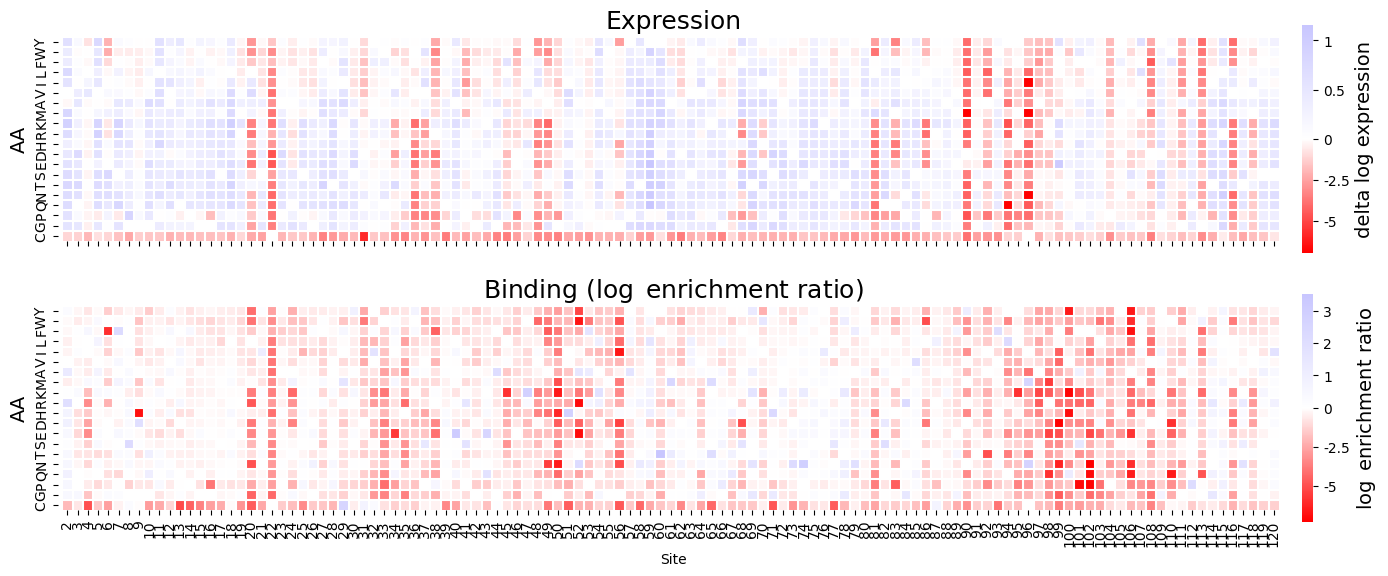

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(14, 6))

make_heatmap(expr_dataset.heavy_dms_style_df, axs[0], "delta log expression")
axs[0].set_title('Expression', fontsize=18)
axs[0].set_xlabel('')
axs[0].set_ylabel("AA", fontsize=14)
axs[0].set_xticklabels([])

make_heatmap(binding_dataset.heavy_dms_style_df, axs[1], "$\log$ enrichment ratio")
axs[1].set_title('Binding ($\log$ enrichment ratio)', fontsize=18)
axs[1].set_ylabel("AA", fontsize=14)

plt.tight_layout()

fig.savefig(os.path.join(figures_dir, "koenig_dms_remade.svg"))

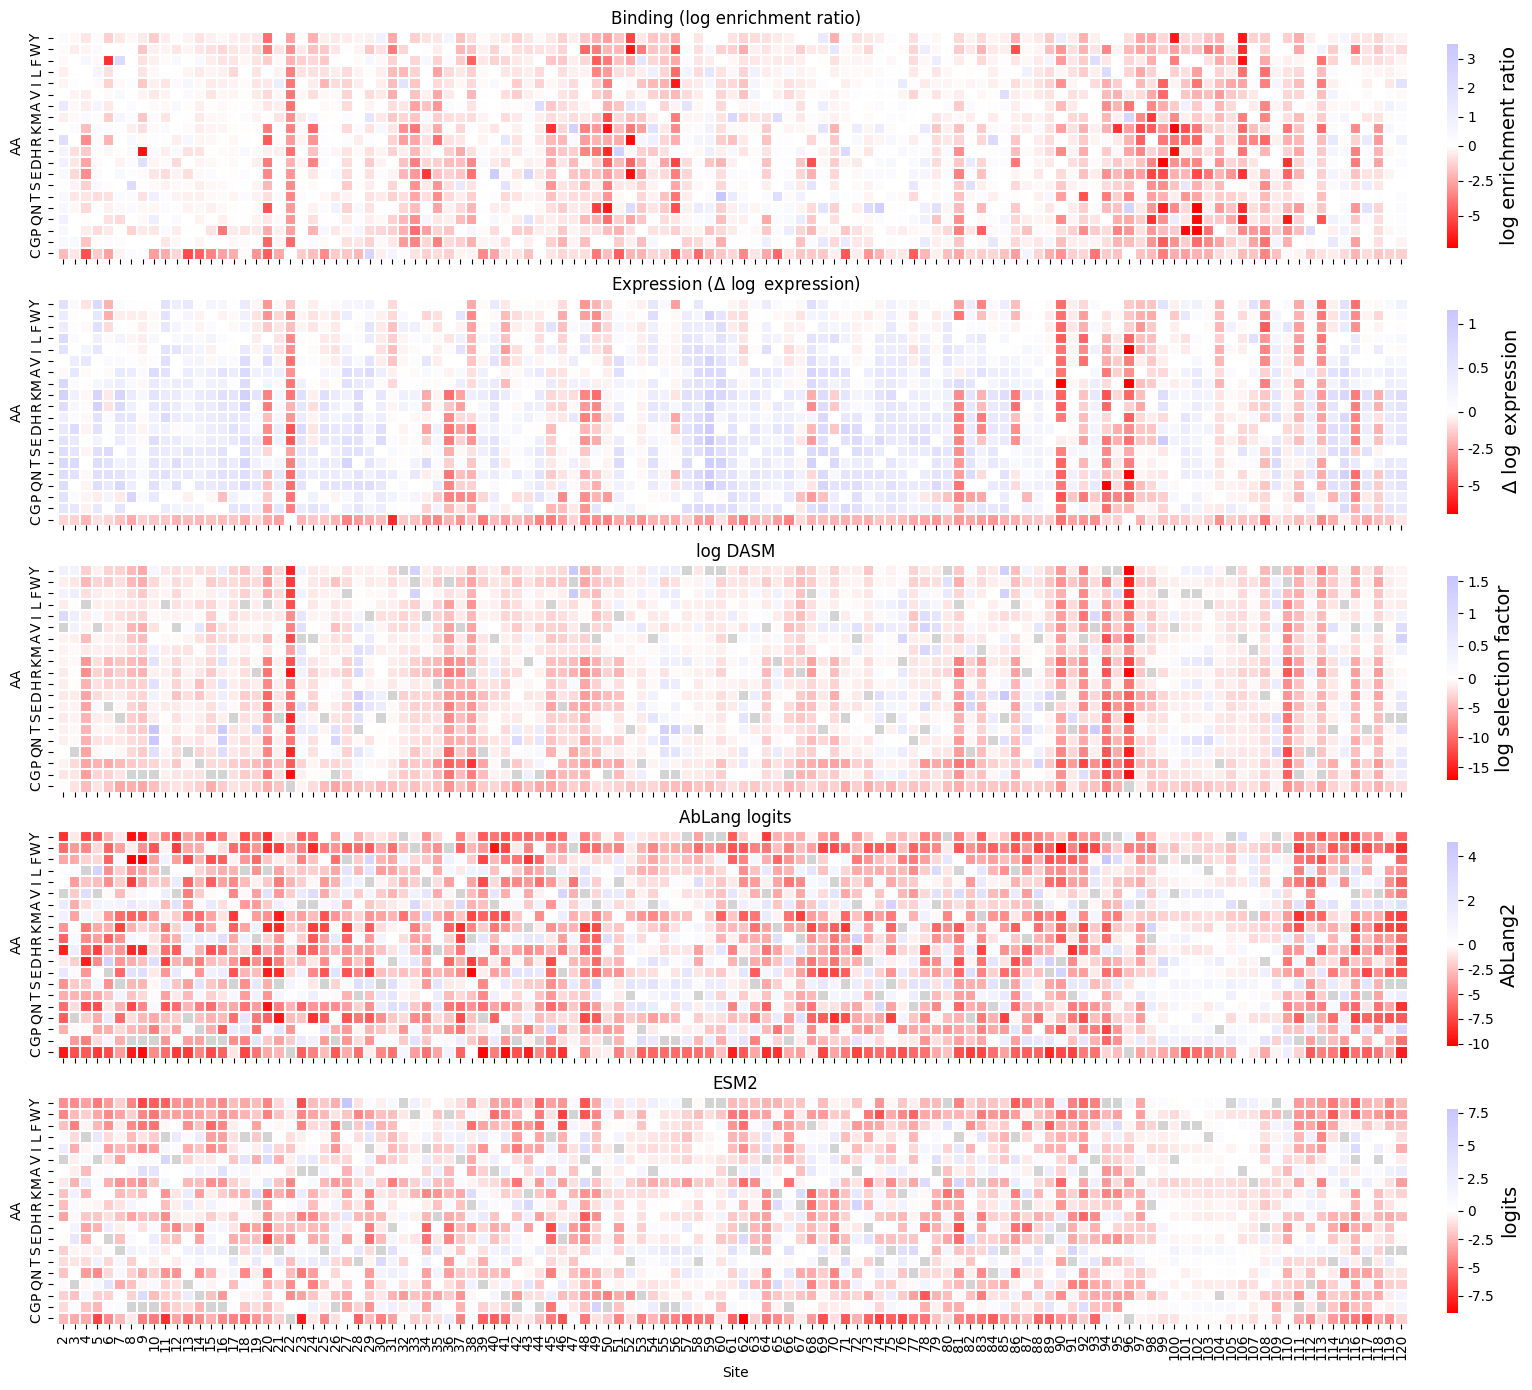

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(30, 14))

make_heatmap(binding_dataset.heavy_dms_style_df, axs[0], "log enrichment ratio")
axs[0].set_title('Binding (log enrichment ratio)')
axs[0].set_xlabel('')
axs[0].set_xticklabels([])

make_heatmap(expr_dataset.heavy_dms_style_df, axs[1], "$\Delta \ \log$ expression")
axs[1].set_title('Expression ($\Delta \ \log$ expression)')
axs[1].set_xlabel('')
axs[1].set_xticklabels([])

make_heatmap(log_dasm_heavy_df, axs[2], "log selection factor")
axs[2].set_title('log DASM')
axs[2].set_xlabel('')
axs[2].set_xticklabels([])

make_heatmap(ablang_logits_heavy_df, axs[3], "AbLang2")
axs[3].set_title('AbLang logits')
axs[3].set_xlabel('')
axs[3].set_xticklabels([])

make_heatmap(esm_heavy_logits_df, axs[4], 'logits')
axs[4].set_title('ESM2')

plt.tight_layout()

fig.savefig(os.path.join(figures_dir, "koenig_heavy_heatmap.svg"), bbox_inches='tight')

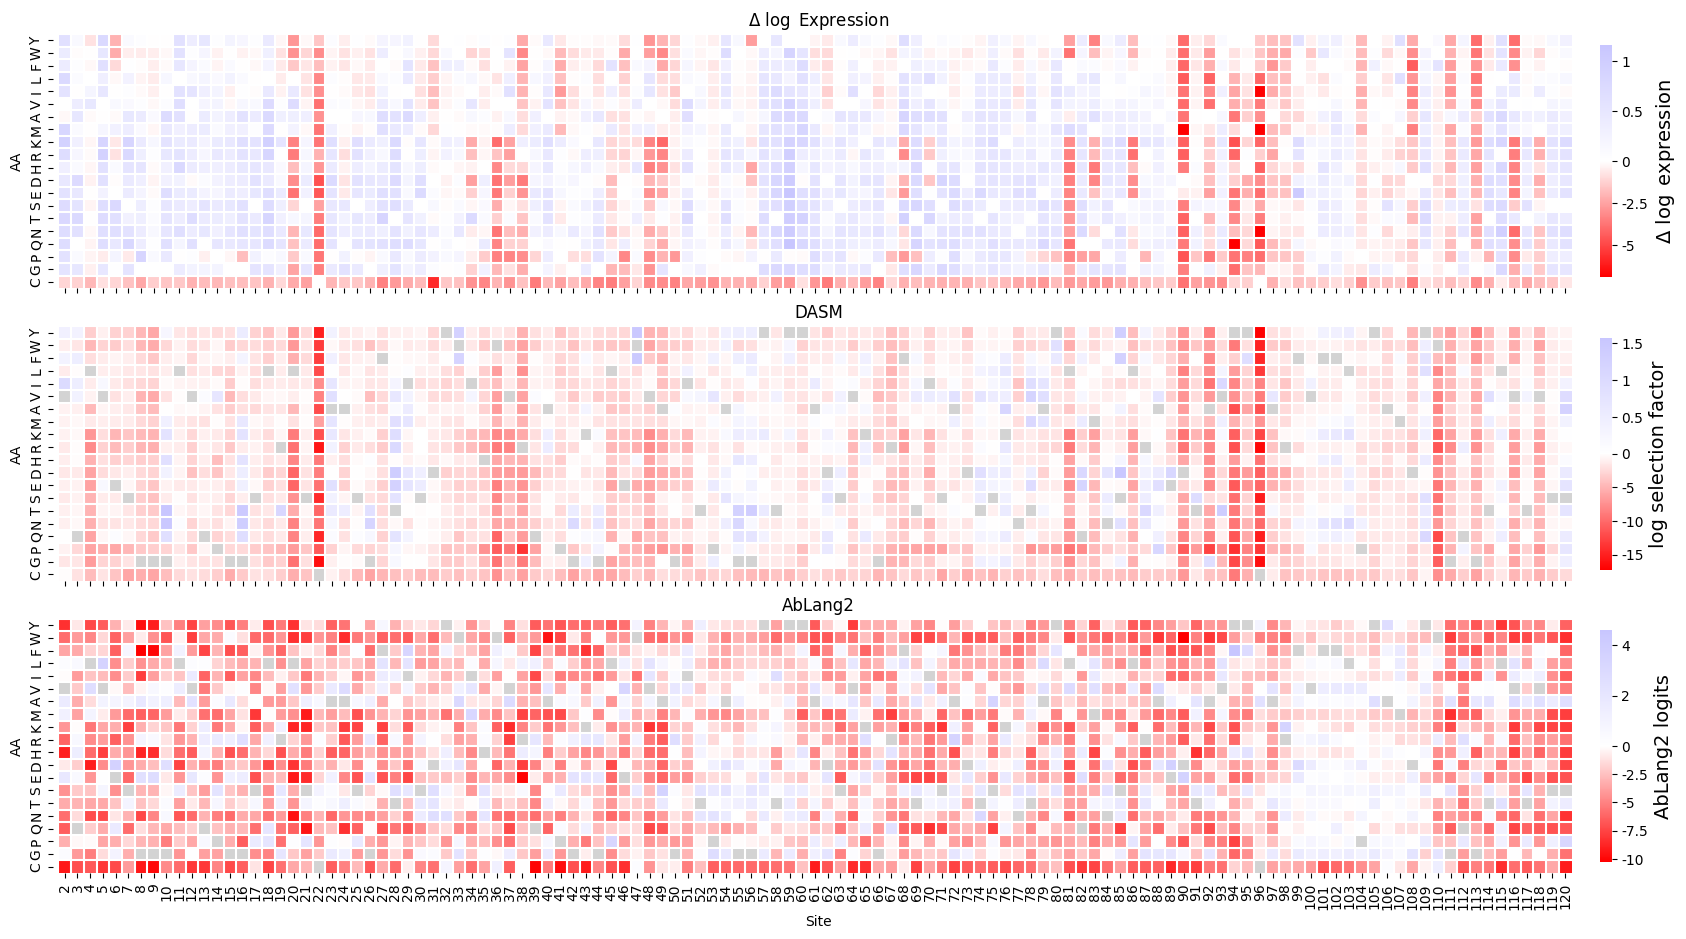

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(17, 9.5))

make_heatmap(expr_dataset.heavy_dms_style_df, axs[0], "$\Delta \ \log$ expression")
axs[0].set_title('$\Delta \ \log$ Expression')
axs[0].set_xlabel('')
axs[0].set_xticklabels([])

make_heatmap(log_dasm_heavy_df, axs[1], "log selection factor")
axs[1].set_title('DASM')
axs[1].set_xlabel('')
axs[1].set_xticklabels([])

make_heatmap(ablang_logits_heavy_df, axs[2], "AbLang2 logits")
axs[2].set_title('AbLang2')

plt.tight_layout()

fig.savefig(os.path.join(figures_dir, "koenig_heavy_heatmap_select.svg"), bbox_inches='tight')

EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLEWVAGITPAGGYTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARFVFFLPYAMDYWGQGTLVTVSS


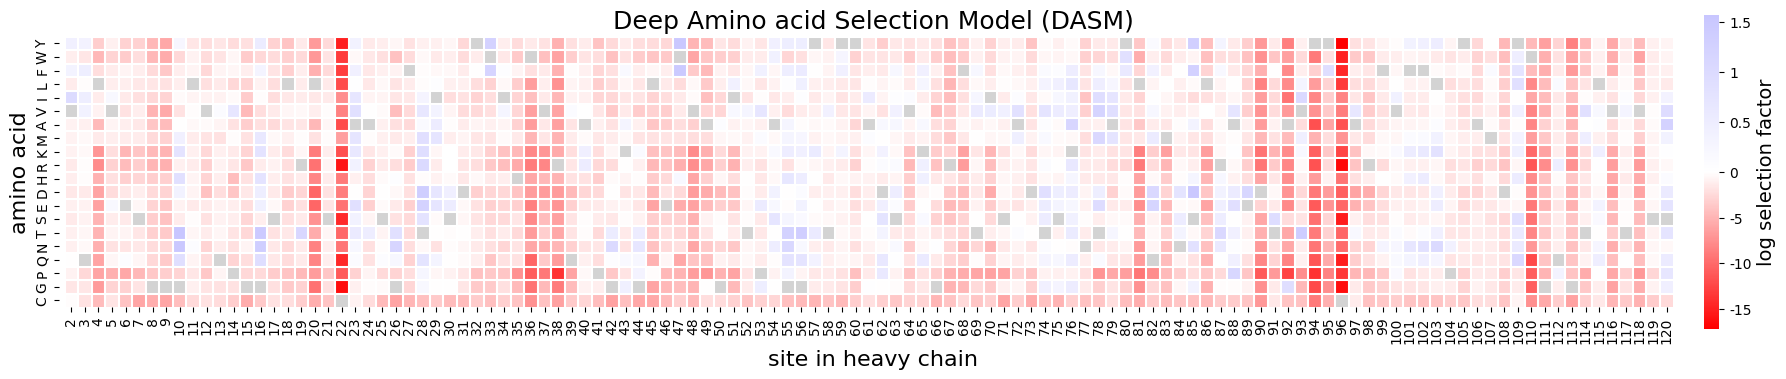

In [17]:
# Saving a version of the heatmap for an early slide
fig, ax = plt.subplots(1, 1, figsize=(18, 4))

print(heavy_wt)

make_heatmap(log_dasm_heavy_df, ax, "log selection factor")
ax.set_title('Deep Amino acid Selection Model (DASM)', fontsize=18)
ax.set_xlabel('site in heavy chain', fontsize=16)
ax.set_ylabel('amino acid', fontsize=16)
plt.tight_layout()

fig.savefig(f"{figures_dir}/koenig2017_sequence_dasm_heatmap.svg")

In [18]:
def get_model_config(model_name, chain):
    """Get model configuration for a specific chain."""
    config = model_predictions[model_name].copy()
    config["data"] = model_predictions[model_name][chain]
    return config

COLUMN_CONFIGS = {
    "neighbor": "codon neighbor",
    "non_neighbor": "codon non-neighbor", 
    "all": "all codons"
}

plot_label_font_size = 15

def create_comparison_grid(dataset, assay_type, chain, models_to_include, reveal_level=2):
    """Creates a figure with comparison plots organized in a grid.
    
    Args:
        dataset: KoenigDataset instance
        assay_type: Type of assay ('Expression' or 'Binding')
        chain: Which chain to analyze ('heavy' or 'light')
        models_to_include: List of model names to include
        reveal_level: How many columns to reveal (default: 2)
    """
    
    # Skip models that don't have data for the requested chain
    available_models = []
    for model_name in models_to_include:
        if model_predictions[model_name][chain] is not None:
            available_models.append(model_name)
        else:
            print(f"Skipping {model_name} - no {chain} chain predictions available")
    
    if not available_models:
        raise ValueError(f"No models available for {chain} chain")

    dms_style_df = getattr(dataset, f"{chain}_dms_style_df")
    neighbor_indicator = getattr(dataset, f"{chain}_neighbor_indicator")
    
    assert neighbor_indicator.shape == dms_style_df.shape, f"Size mismatch between neighbor_indicator ({neighbor_indicator.shape}) and dms_style_df ({dms_style_df.shape})"
    
    x_min, x_max = dms_style_df.min().min(), dms_style_df.max().max()

    # Prepare datasets for neighbor/non-neighbor/all 
    datasets = {}
    for col_key, col_suffix in COLUMN_CONFIGS.items():
        df = dms_style_df.copy()
        if col_key == "all":
            # Store the neighbor status for later
            neighbor_info = np.where(neighbor_indicator, 
                                   "Codon neighbor", 
                                   "Non-neighbor")
        else:
            mask = neighbor_indicator if col_key == "neighbor" else ~neighbor_indicator
            df.values[~mask] = np.nan
            neighbor_info = ("Codon neighbor" if col_key == "neighbor" else "Non-neighbor")
            
        # Store both the df and neighbor info
        datasets[f"{assay_type} ({col_suffix})"] = (df, neighbor_info)

    # Create figure
    row_count = len(available_models)
    fig, axs = plt.subplots(row_count, 3, figsize=(10, 3*row_count+1), sharex="col", sharey="row")
    if row_count == 1:
        axs = axs.reshape(1, -1)  # Handle single row case
        
    # Set column titles
    col_titles = [f"{assay_type} ({COLUMN_CONFIGS[k]})" for k in ["neighbor", "non_neighbor", "all"]]
    for ax, title in zip(axs[0], col_titles):
        # Make a nicer title as suggested by Hugh.
        short_title = re.search(r'\((.*?)\)', title).group(1)
        short_title_remap = {"codon neighbor": "Single mutation away",
                             "codon non-neighbor": "Multiple mutations away",
                             "all codons": "All codon mutations"}
        ax.set_title(short_title_remap.get(short_title, short_title), fontsize=plot_label_font_size)
        
    # Set row titles and store axes
    comparison_dict = {}
    for i, model_key in enumerate(available_models):
        row_label = model_predictions[model_key]["label"]
        axs[i, 0].set_ylabel(row_label)
        for j, col_title in enumerate(col_titles):
            comparison_dict[(row_label, col_title)] = axs[i, j]
    
    # Process prediction dataframes with sign flipping if needed
    prediction_dfs = {}
    for k in available_models:
        config = model_predictions[k]
        df = config[chain].copy()
        if config["flip_sign"]:
            df = -df
            # Update the label to reflect the sign flip
            prediction_dfs[f"-{config['label']}"] = df
        else:
            prediction_dfs[config['label']] = df

    reveals = [(row_label, col_title) 
              for row_label in prediction_dfs.keys()
              for j, col_title in enumerate(col_titles)
              if j <= reveal_level]
    
    y_lims = {
        row_label: (pred_df.min().min(), pred_df.max().max())
        for row_label, pred_df in prediction_dfs.items()
    }
             
    correlations = []
    for row_label, col_title in reveals:
        ax = comparison_dict[(row_label.lstrip('-'), col_title)]  # Strip minus sign for dict lookup
        df, neighbor_info = datasets[col_title]
        y_min, y_max = y_lims[row_label]
        corr, _ = plot_variant_comparison(df, col_title, prediction_dfs[row_label], row_label, 
                              neighbor_info, ax=ax, x_lims=(x_min, x_max), y_lims=(y_min, y_max))
        correlations.append([f"{col_title} ({chain})", row_label, corr])
        # let the xlabel be the col_title with the parenthetical stripped off
        xlabel = col_title.split('(')[0].strip()
        translate_xlabel_dict = {"Expression": "$\Delta \ \log$ Expression", "Binding": "Binding"}
        xlabel = translate_xlabel_dict[xlabel]
        ax.set_xlabel(xlabel, fontsize=plot_label_font_size)
        ax.set_ylabel(row_label, fontsize=plot_label_font_size)
    
    for i, model_key in enumerate(available_models):
        for j, col_title in enumerate(col_titles):
            ax = axs[i, j]
            if j > reveal_level:  # Hide x-axis labels for non-revealed columns
                ax.set_xlabel("")
                ax.set_xticklabels([])

    plt.tight_layout()
        
    return fig, correlations

In [19]:
# Initialize correlation tracking
correlation_rows = []

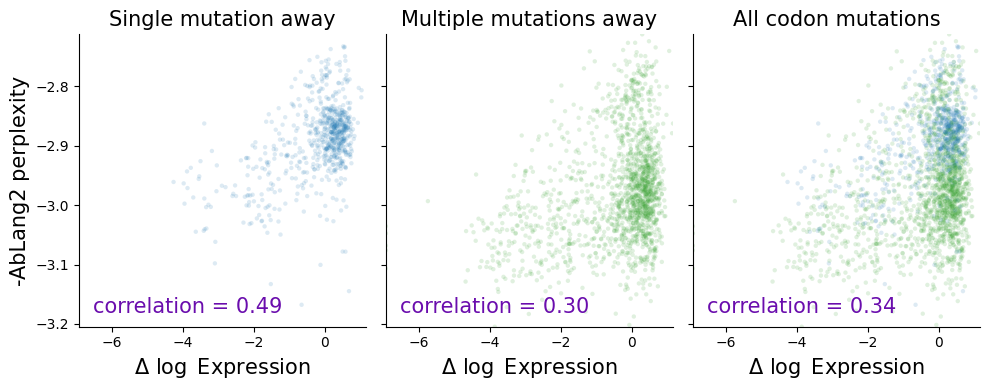

In [20]:
models_to_use = ["AbLang2"]
fig, corrs = create_comparison_grid(expr_dataset, "Expression", "heavy", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_ablang_expression_reveal_2.svg")
correlation_rows.extend(corrs)

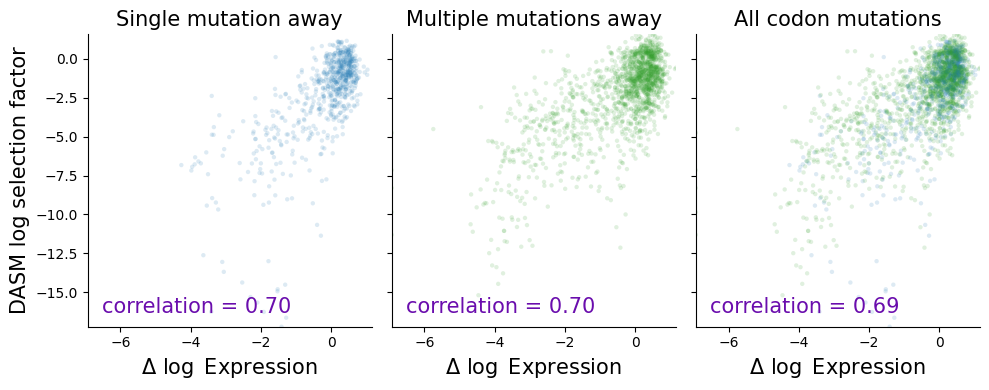

In [21]:
models_to_use = ["DASM"]
fig, corrs = create_comparison_grid(expr_dataset, "Expression", "heavy", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_dasm_expression.svg")

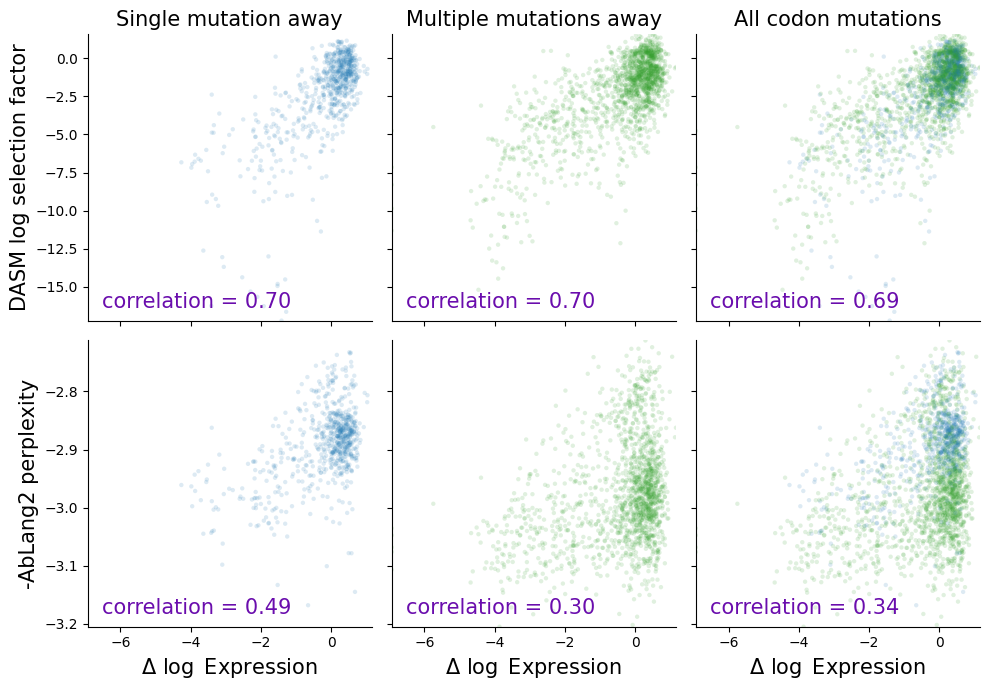

In [22]:
models_to_use = ["DASM", "AbLang2"]
fig, corrs = create_comparison_grid(expr_dataset, "Expression", "heavy", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_dasm_ablang_expression.svg")
correlation_rows.extend(corrs)

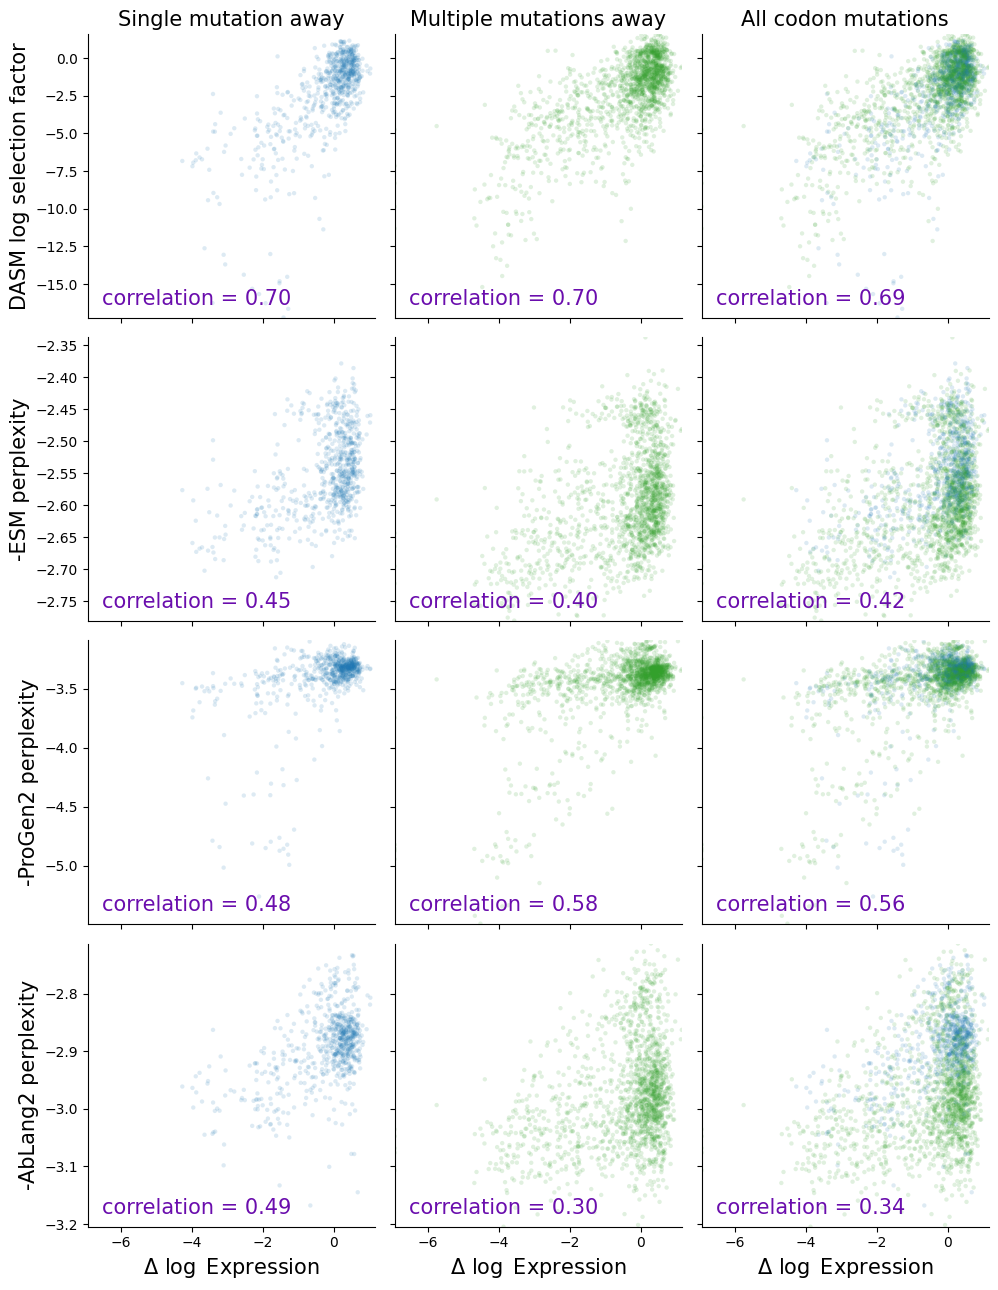

In [23]:
models_to_use = ["DASM", "ESM", "ProGen2", "AbLang2"]
fig, corrs = create_comparison_grid(expr_dataset, "Expression", "heavy", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_expression_heavy.svg")
correlation_rows.extend(corrs)

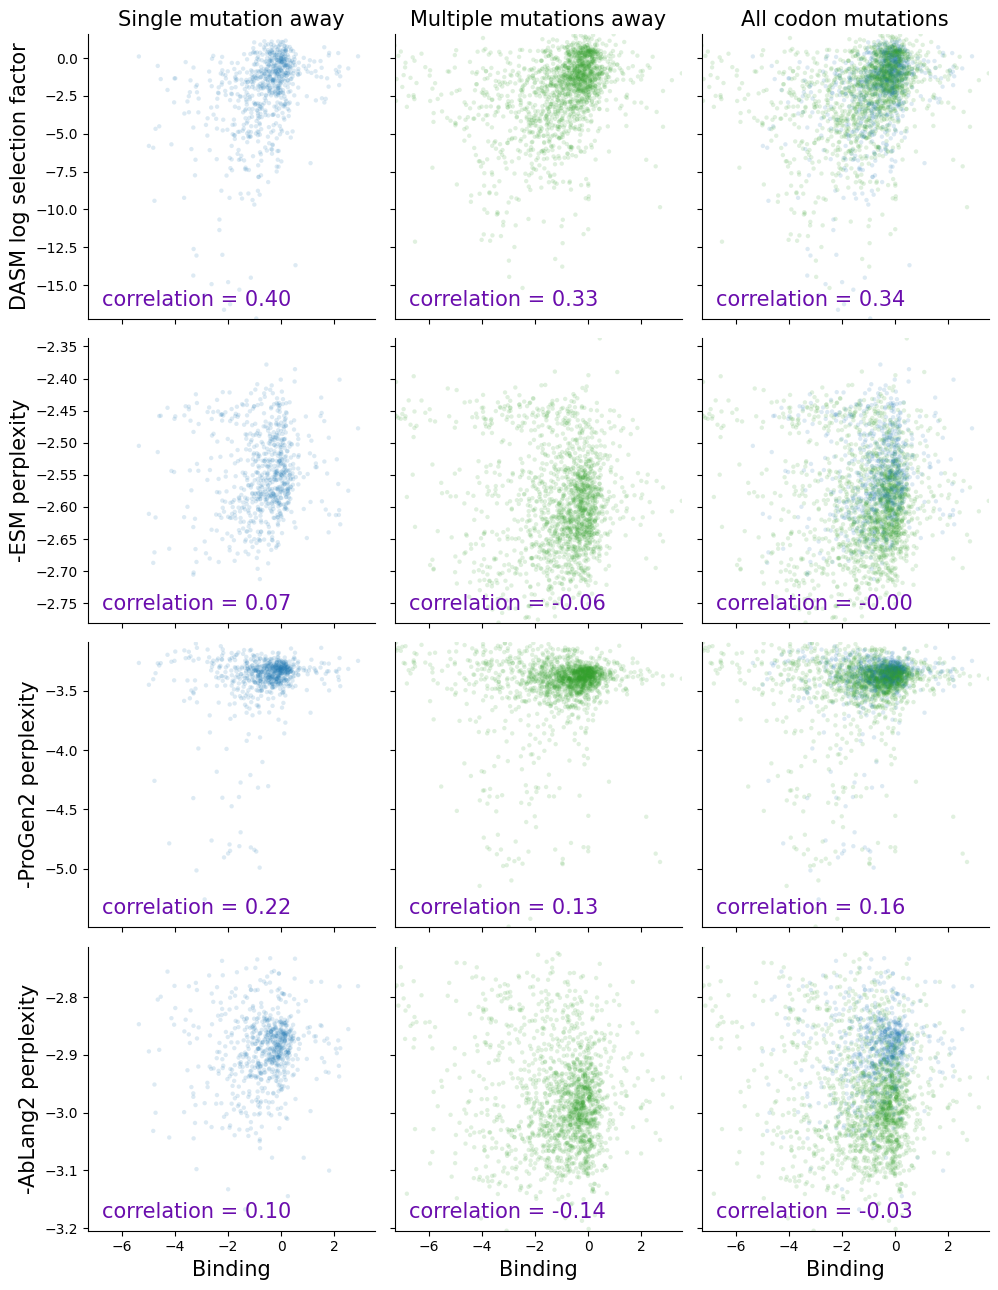

In [24]:
models_to_use = ["DASM", "ESM", "ProGen2", "AbLang2"]
fig, corrs = create_comparison_grid(binding_dataset, "Binding", "heavy", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_binding_heavy.svg")
correlation_rows.extend(corrs)

## Light Chain Analysis

Now let's run the same analyses for the light chain:

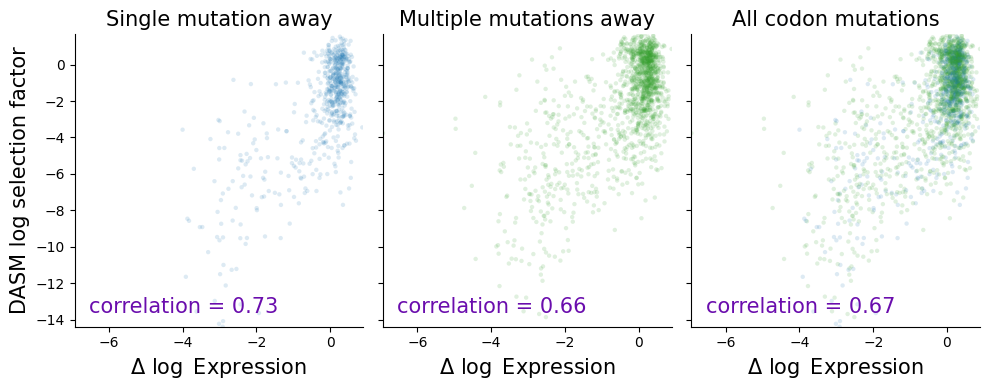

In [25]:
# Light chain comparisons for expression data
light_correlation_rows = []

# DASM only
models_to_use = ["DASM"]
fig, corrs = create_comparison_grid(expr_dataset, "Expression", "light", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_dasm_expression_light.svg")
light_correlation_rows.extend(corrs)

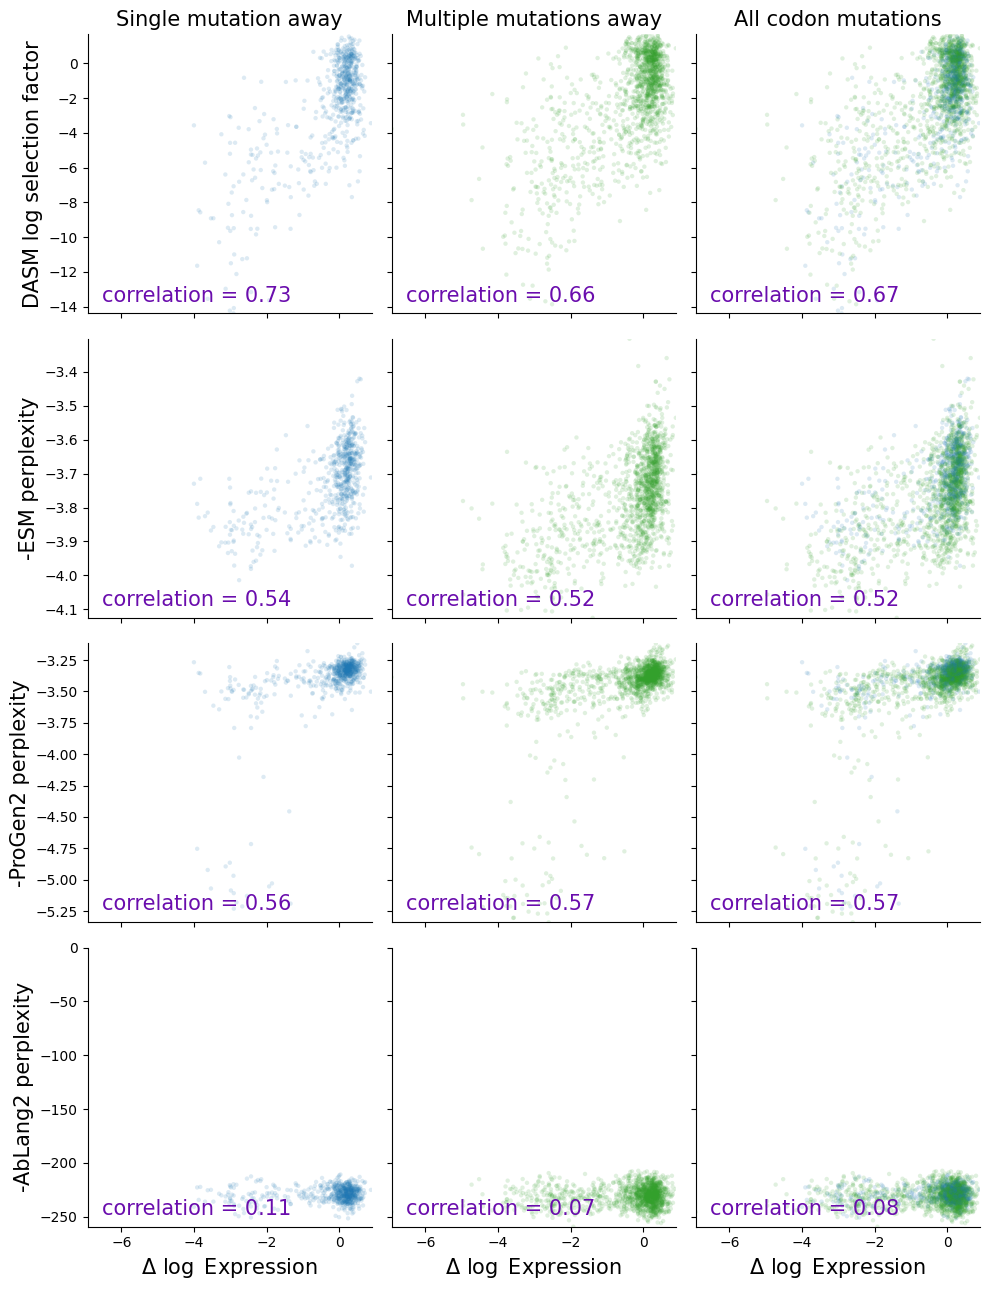

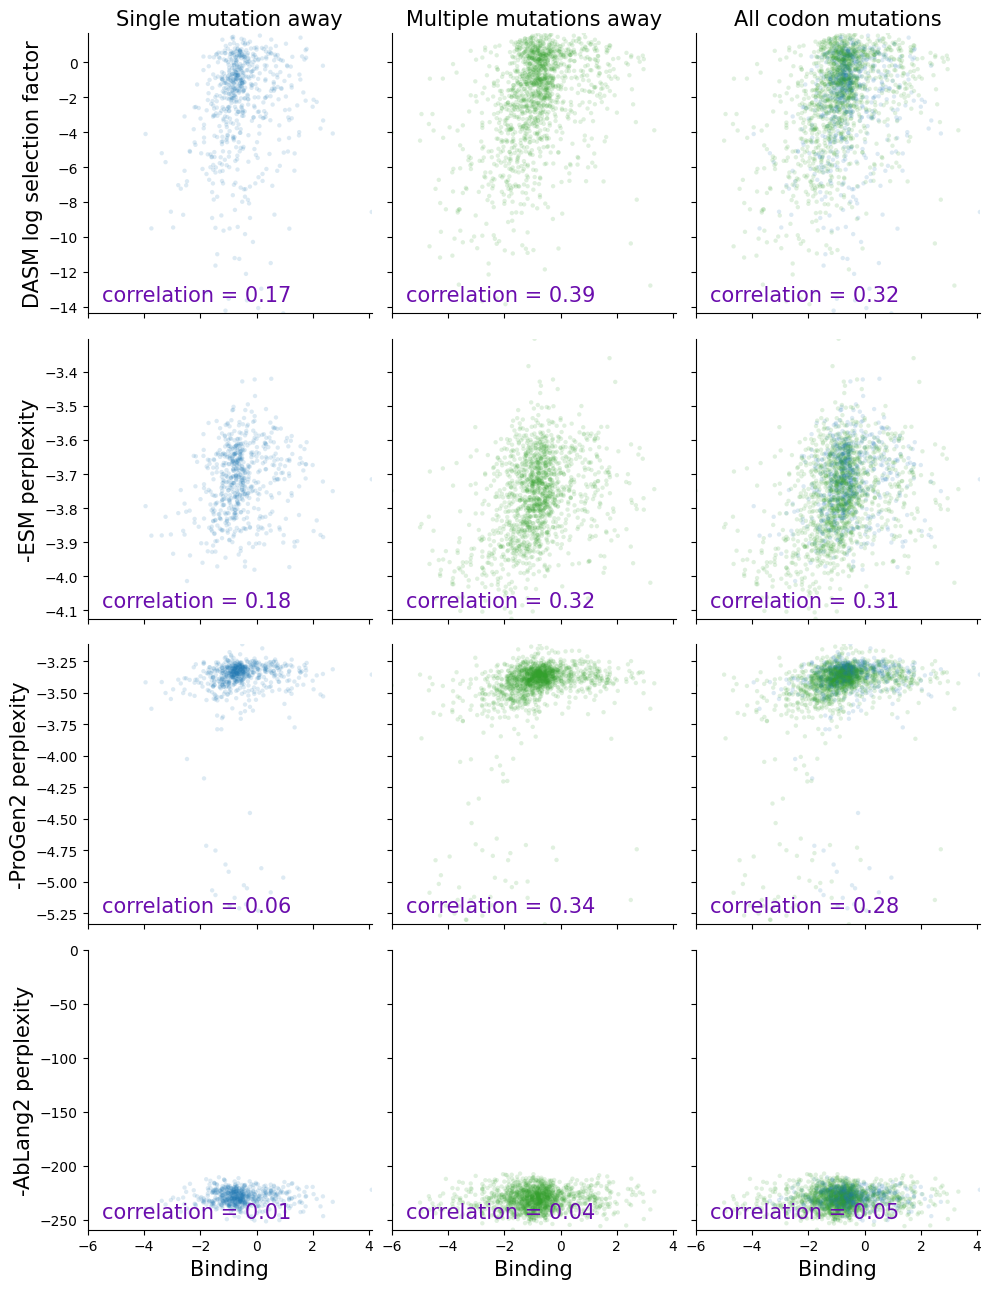

In [26]:
models_to_use = ["DASM", "ESM", "ProGen2", "AbLang2"]
fig, corrs = create_comparison_grid(expr_dataset, "Expression", "light", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_expression_light.svg")
light_correlation_rows.extend(corrs)

models_to_use = ["DASM", "ESM", "ProGen2", "AbLang2"]
fig, corrs = create_comparison_grid(binding_dataset, "Binding", "light", models_to_use, reveal_level=2)
fig.savefig(f"{figures_dir}/koenig_binding_light.svg")
light_correlation_rows.extend(corrs)

## Combined Heavy and Light Chain Results

In [27]:
# Combine heavy and light chain correlations
all_correlations = correlation_rows + light_correlation_rows

# Create combined dataframe
combined_correlations_df = pd.DataFrame(all_correlations, columns=["Dataset", "Model", "Correlation"])
combined_correlations_df = combined_correlations_df.drop_duplicates()

# Filter for "all codons" results only
combined_correlations_df = combined_correlations_df[combined_correlations_df["Dataset"].str.contains("all codons")]

# Extract chain information
combined_correlations_df["Chain"] = combined_correlations_df["Dataset"].str.extract(r'\((heavy|light)\)')

# Clean up dataset names
combined_correlations_df["Dataset"] = combined_correlations_df["Dataset"].str.replace(r" \(all codons\) \((heavy|light)\)", "", regex=True)

# Rename models
combined_correlations_df["Model"] = combined_correlations_df["Model"].replace({
    "-AbLang2 perplexity": "AbLang2", 
    "-ESM perplexity": "ESM", 
    "-ProGen2 perplexity": "ProGen2",
    "DASM log selection factor": "DASM"
})

# Pivot to show heavy and light side by side
correlation_pivot = combined_correlations_df.pivot_table(
    index=["Dataset", "Model"], 
    columns="Chain", 
    values="Correlation"
).round(3)

# Save detailed results
combined_correlations_df.to_csv("_output/correlations_koenig_paired.csv", index=False)

# Display the pivot table
print("Model Correlations by Chain:")
print(correlation_pivot)

Model Correlations by Chain:
Chain               heavy  light
Dataset    Model                
Binding    AbLang2 -0.032  0.049
           DASM     0.335  0.316
           ESM     -0.001  0.308
           ProGen2  0.156  0.276
Expression AbLang2  0.344  0.084
           DASM     0.688  0.674
           ESM      0.418  0.524
           ProGen2  0.559  0.568


In [28]:
# Generate LaTeX table from correlation results
def generate_latex_table(correlation_pivot):
    """Generate LaTeX table from correlation pivot table."""
    
    # Create the table header
    latex_lines = [
        "\\begin{tabular}{lcccc}",
        "\\toprule",
        "& \\multicolumn{2}{c}{Binding} & \\multicolumn{2}{c}{Expression} \\\\",
        "\\cmidrule(lr){2-3} \\cmidrule(lr){4-5}",
        "Model & Heavy & Light & Heavy & Light \\\\"
    ]
    
    # Add midrule
    latex_lines.append("\\midrule")
    
    # Process each model
    for model in ["AbLang2", "DASM", "ESM", "ProGen2"]:
        # Get values for each dataset/chain combination
        binding_heavy = correlation_pivot.loc[("Binding", model), "heavy"]
        binding_light = correlation_pivot.loc[("Binding", model), "light"] 
        expr_heavy = correlation_pivot.loc[("Expression", model), "heavy"]
        expr_light = correlation_pivot.loc[("Expression", model), "light"]
        
        # Format values (3 decimal places)
        values = [f"{val:.3f}" for val in [binding_heavy, binding_light, expr_heavy, expr_light]]
        
        # Bold the DASM values 
        if model == "DASM":
            values = [f"\\textbf{{{val}}}" for val in values]
        
        # Create the row
        row = f"{model} & {' & '.join(values)} \\\\"
        latex_lines.append(row)
    
    # Add bottom rule
    latex_lines.extend([
        "\\bottomrule",
        "\\end{tabular}"
    ])
    
    return "\n".join(latex_lines)

# Generate and display the LaTeX table
latex_table = generate_latex_table(correlation_pivot)
print("LaTeX table, needs hand editing to move bold to ESM for light binding:")
print(latex_table)

LaTeX table, needs hand editing to move bold to ESM for light binding:
\begin{tabular}{lcccc}
\toprule
& \multicolumn{2}{c}{Binding} & \multicolumn{2}{c}{Expression} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
Model & Heavy & Light & Heavy & Light \\
\midrule
AbLang2 & -0.032 & 0.049 & 0.344 & 0.084 \\
DASM & \textbf{0.335} & \textbf{0.316} & \textbf{0.688} & \textbf{0.674} \\
ESM & -0.001 & 0.308 & 0.418 & 0.524 \\
ProGen2 & 0.156 & 0.276 & 0.559 & 0.568 \\
\bottomrule
\end{tabular}


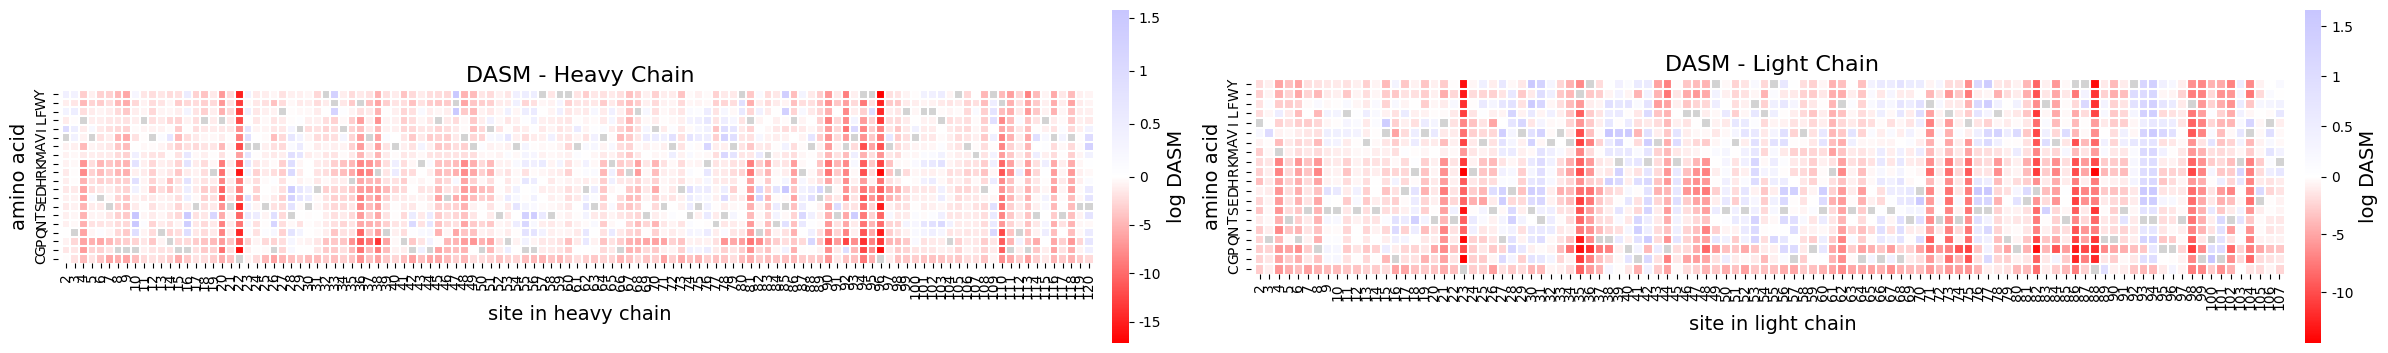

In [29]:
# Create side-by-side heatmaps for heavy and light chains
def plot_paired_heatmaps(dataset, model_data_heavy, model_data_light, model_name, save_path=None):
    """Plot heavy and light chain heatmaps side by side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 4))
    
    # Heavy chain
    make_heatmap(model_data_heavy, ax1, f"log {model_name}")
    ax1.set_title(f'{model_name} - Heavy Chain', fontsize=16)
    ax1.set_xlabel('site in heavy chain', fontsize=14)
    ax1.set_ylabel('amino acid', fontsize=14)
    
    # Light chain  
    make_heatmap(model_data_light, ax2, f"log {model_name}")
    ax2.set_title(f'{model_name} - Light Chain', fontsize=16)
    ax2.set_xlabel('site in light chain', fontsize=14)
    ax2.set_ylabel('amino acid', fontsize=14)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path)
    return fig

# Plot DASM predictions for both chains
fig = plot_paired_heatmaps(
    expr_dataset, 
    log_dasm_heavy_df, 
    log_dasm_light_df, 
    "DASM",
    f"{figures_dir}/koenig_dasm_paired_heatmap.svg"
)

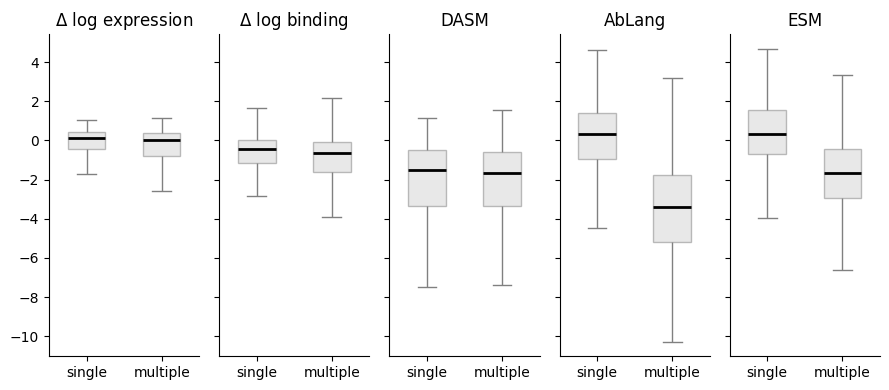

In [30]:
def apply_nan_mask(df, reference_df):
   """Apply nan pattern from reference to df."""
   result = df.copy()
   result[reference_df.isna()] = np.nan
   return result

def plot_neighbor_data_comparison(df, neighbor_indicator, ax):
   # Get non-nan values for each group
   neighbor_vals = df.values[neighbor_indicator & ~np.isnan(df.values)]
   non_neighbor_vals = df.values[~neighbor_indicator & ~np.isnan(df.values)]
   
   data = [neighbor_vals.flatten(), non_neighbor_vals.flatten()]

   data = pd.DataFrame({
       'Group': ['single'] * len(neighbor_vals) + ['multiple'] * len(non_neighbor_vals),
       'Value': np.concatenate([neighbor_vals.flatten(), non_neighbor_vals.flatten()])
   })
   
   sns.boxplot(data=data, x='Group', y='Value', ax=ax, 
               showfliers=False, 
               width=0.5,
               color='lightgray',
               medianprops={'color': 'black', 'linewidth': 2},
               boxprops={'alpha': 0.5},
               whiskerprops={'color': 'gray'},
               capprops={'color': 'gray'})
   
   ax.set_xlabel('')
   ax.set_ylabel('')

       
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(9, 4), sharey=True)

expr_df_masked = apply_nan_mask(expr_dataset.heavy_dms_style_df, ablang_logits_heavy_df) 
binding_df_masked = apply_nan_mask(binding_dataset.heavy_dms_style_df, ablang_logits_heavy_df)

plot_neighbor_data_comparison(expr_df_masked, expr_dataset.heavy_neighbor_indicator, ax1)
ax1.set_title('$\Delta$ log expression')

plot_neighbor_data_comparison(binding_df_masked, binding_dataset.heavy_neighbor_indicator, ax2)
ax2.set_title('$\Delta$ log binding')

plot_neighbor_data_comparison(log_dasm_heavy_df, expr_dataset.heavy_neighbor_indicator, ax3)
ax3.set_title('DASM')

plot_neighbor_data_comparison(ablang_logits_heavy_df, expr_dataset.heavy_neighbor_indicator, ax4)
ax4.set_title('AbLang')

plot_neighbor_data_comparison(esm_heavy_logits_df, expr_dataset.heavy_neighbor_indicator, ax5)
ax5.set_title('ESM')

sns.despine()
plt.tight_layout()

fig.savefig(f"{figures_dir}/koenig_neighbor_comparison.svg")

### Comparing with mutability

In [31]:
def log_neutral_aa_probs_of(nt_seq): 
    nt_idx_tensor = nt_idx_tensor_of_str(nt_seq)

    ([nt_rates], [nt_csps]) = trimmed_shm_model_outputs_of_crepe(neutral_crepe, [nt_seq])

    branch_length = 0.1
    mut_probs = 1.0 - torch.exp(-branch_length * nt_rates)

    neutral_aa_probs = molevol.neutral_aa_probs(
        nt_idx_tensor.reshape(-1, 3),
        mut_probs.reshape(-1, 3),
        nt_csps.reshape(-1, 3, 4),
    )

    return (torch.log(neutral_aa_probs)).numpy()

log_neutral_aa_probs = pd.DataFrame(log_neutral_aa_probs_of(expr_dataset.heavy_consensus_backtrans).T)
log_neutral_aa_probs.index = list(AA_STR_SORTED)
log_neutral_aa_probs.columns = range(1, len(log_neutral_aa_probs.columns) + 1)
log_neutral_aa_probs = trim_df(log_neutral_aa_probs, chain="heavy")

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_98572/754251545.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


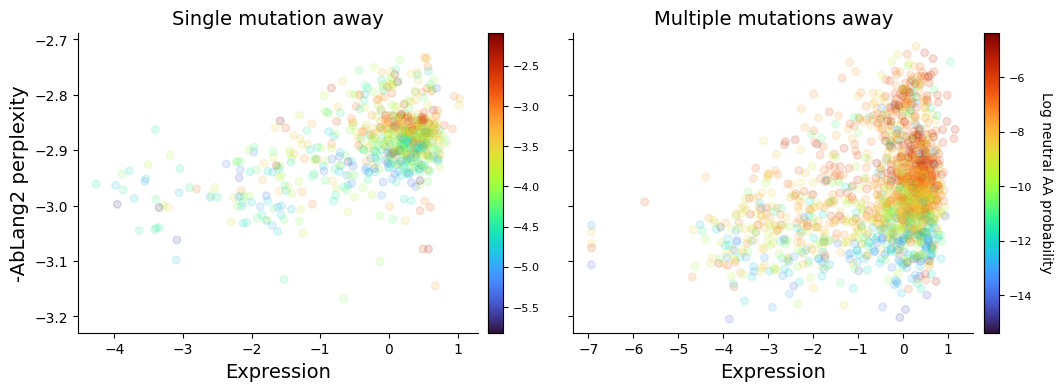

In [32]:
def plot_shm_comparison(dataset, model_perplexity_df, neighbor_indicator, log_neutral_aa_probs, cmap='turbo'):
    """
    Creates a simplified version of the AbLang2 comparison plot with two panels,
    each with its own thin colorbar.
    
    Args:
        dataset: The dataset with heavy_dms_style_df
        model_perplexity_df: The model perplexity dataframe
        neighbor_indicator: Boolean array indicating neighbor status
        log_neutral_aa_probs: DataFrame with values for coloring the points (viridis scheme)
        cmap: The colormap to use (default: 'turbo')
    """
    
    panel_width = 4.0  # Original panel width
    cbar_width = 0.15  # Thinner colorbar
    spacing = 0.7      # Space between panels and between panel and its colorbar
    
    # Calculate total width
    total_width = panel_width * 2 + cbar_width * 2 + spacing * 3
    
    # Create figure with appropriate size and increased right margin for colorbar label
    fig = plt.figure(figsize=(total_width, 4))
    
    # Adjust right margin to accommodate colorbar label
    right_margin = 0.95
    
    # Define positions for each axis with adjusted margins
    ax1_pos = [0.08, 0.15, panel_width/total_width, 0.75]  # [left, bottom, width, height]
    cbar1_pos = [0.08 + panel_width/total_width + 0.01, 0.15, cbar_width/total_width, 0.75]
    ax2_pos = [cbar1_pos[0] + cbar_width/total_width + spacing/total_width, 0.15, panel_width/total_width, 0.75]
    cbar2_pos = [ax2_pos[0] + panel_width/total_width + 0.01, 0.15, cbar_width/total_width, 0.75]
    
    # Create axes manually
    ax1 = fig.add_axes(ax1_pos)
    cax1 = fig.add_axes(cbar1_pos)
    ax2 = fig.add_axes(ax2_pos, sharey=ax1)
    cax2 = fig.add_axes(cbar2_pos)
    
    # Hide y-tick labels on second panel
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    # Prepare data for each panel
    # Panel 1: Neighbor data
    x_neighbor = dataset.heavy_dms_style_df.copy()
    x_neighbor.values[~neighbor_indicator] = np.nan
    y_neighbor = -model_perplexity_df.copy()
    y_neighbor.values[~neighbor_indicator] = np.nan
    c_neighbor = log_neutral_aa_probs.copy()
    c_neighbor.values[~neighbor_indicator] = np.nan
    
    # Panel 2: Non-neighbor data
    x_non_neighbor = dataset.heavy_dms_style_df.copy()
    x_non_neighbor.values[neighbor_indicator] = np.nan
    y_non_neighbor = -model_perplexity_df.copy()
    y_non_neighbor.values[neighbor_indicator] = np.nan
    c_non_neighbor = log_neutral_aa_probs.copy()
    c_non_neighbor.values[neighbor_indicator] = np.nan
    
    # Process and plot each panel
    datasets = [
        (x_neighbor, y_neighbor, c_neighbor, "Single mutation away", ax1, cax1),
        (x_non_neighbor, y_non_neighbor, c_non_neighbor, "Multiple mutations away", ax2, cax2)
    ]
    
    for i, (x_data, y_data, c_data, title, ax, cax) in enumerate(datasets):
        # Flatten data for plotting
        x_values = x_data.values.flatten()
        y_values = y_data.values.flatten()
        c_values = c_data.values.flatten()
        
        # Remove NaN values
        mask = ~np.isnan(x_values) & ~np.isnan(y_values) & ~np.isnan(c_values)
        x_filtered = x_values[mask]
        y_filtered = y_values[mask]
        c_filtered = c_values[mask]
        
        # Randomize the order of points
        if len(x_filtered) > 0:
            random_indices = np.random.permutation(len(x_filtered))
            x_filtered = x_filtered[random_indices]
            y_filtered = y_filtered[random_indices]
            c_filtered = c_filtered[random_indices]
            
            # Get min/max for this dataset only
            vmin, vmax = np.nanmin(c_filtered), np.nanmax(c_filtered)
            
            # Create scatter plot with viridis coloring
            ax.scatter(x_filtered, y_filtered, alpha=0.15, s=30, 
                      c=c_filtered, cmap=cmap, vmin=vmin, vmax=vmax)
            
            # Create a separate mappable for the colorbar with full opacity
            norm = plt.Normalize(vmin=vmin, vmax=vmax)
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            
            # Add colorbar for this panel
            cbar = fig.colorbar(sm, cax=cax)
            # Make colorbar ticks and label smaller to fit thin colorbar
            cbar.ax.tick_params(labelsize=8)
            
            if i == 1:
                # Adjust colorbar label position to ensure it's within the figure boundaries
                cbar.set_label('Log neutral AA probability', fontsize=10, labelpad=5, rotation=270, va='bottom')
        
        # Add title and xlabel to each panel
        ax.set_title(f"{title}", fontsize=14)
        ax.set_xlabel("Expression", fontsize=14)
    
    # Set common y-label only on left panel
    ax1.set_ylabel("-AbLang2 perplexity", fontsize=14)
    
    # Style adjustments
    sns.despine()
    
    return fig, [ax1, ax2]

# Example usage:
fig, axs = plot_shm_comparison(
    expr_dataset, 
    ablang_perplexity_heavy_df,
    expr_dataset.heavy_neighbor_indicator,
    log_neutral_aa_probs, 
    cmap='turbo'
)

# Ensure tight layout BEFORE saving
fig.tight_layout()

# Additional safeguard: adjust the figure's bounding box to ensure everything fits
fig.savefig(f"{figures_dir}/koenig_ablang_shm_colors.svg", bbox_inches='tight')

Neutral perplexity correlation: 0.60


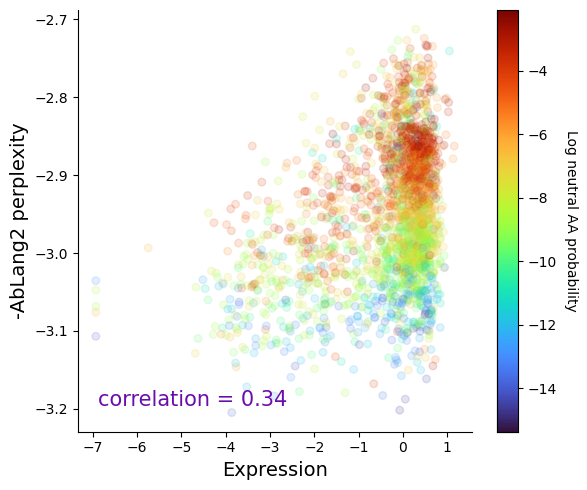

In [33]:
def plot_simplified_comparison(dataset, model_perplexity_df, log_neutral_aa_probs, cmap='turbo'):
    """
    Creates a simplified version of the plot with all mutations combined
    and correlation information displayed.
    
    Args:
        dataset: The dataset with heavy_dms_style_df
        model_perplexity_df: The model perplexity dataframe
        log_neutral_aa_probs: DataFrame with values for coloring the points
        cmap: The colormap to use (default: 'turbo')
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Flatten data for plotting
    x_values = dataset.heavy_dms_style_df.values.flatten()
    y_values = -model_perplexity_df.values.flatten()
    c_values = log_neutral_aa_probs.values.flatten()
    
    # Remove NaN values
    mask = ~np.isnan(x_values) & ~np.isnan(y_values) & ~np.isnan(c_values)
    x_filtered = x_values[mask]
    y_filtered = y_values[mask]
    c_filtered = c_values[mask]
    
    # Randomize the order of points to avoid plotting bias
    if len(x_filtered) > 0:
        random_indices = np.random.permutation(len(x_filtered))
        x_filtered = x_filtered[random_indices]
        y_filtered = y_filtered[random_indices]
        c_filtered = c_filtered[random_indices]
        
        # Get min/max for coloring
        vmin, vmax = np.nanmin(c_filtered), np.nanmax(c_filtered)
        
        # Create scatter plot with low alpha
        scatter = ax.scatter(x_filtered, y_filtered, alpha=0.15, s=30, 
                 c=c_filtered, cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Create a separate mappable for the colorbar with full opacity
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        # Add colorbar with full alpha using the separate mappable
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Log neutral AA probability', rotation=270, labelpad=15)
        
        # Calculate correlations
        expr_perplexity_corr = np.corrcoef(x_filtered, y_filtered)[0, 1]
        neutral_perplexity_corr = np.corrcoef(c_filtered, y_filtered)[0, 1]
        
        # Add correlation text
        ax.text(
            0.05,
            0.1,
            f"correlation = {expr_perplexity_corr:.2f}",
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=15,
            color="#6a0dad",
        )

        print(f"Neutral perplexity correlation: {neutral_perplexity_corr:.2f}")

    # Set labels
    ax.set_xlabel("Expression", fontsize=14)
    ax.set_ylabel("-AbLang2 perplexity", fontsize=14)
    
    # Style adjustments
    sns.despine()
    
    return fig, ax

# Example usage:
fig, ax = plot_simplified_comparison(
    expr_dataset, 
    ablang_perplexity_heavy_df,
    log_neutral_aa_probs, 
    cmap='turbo'
)

# Ensure tight layout
fig.tight_layout()

# Save figure
fig.savefig(f"{figures_dir}/koenig_ablang_shm_colors.svg", bbox_inches='tight')

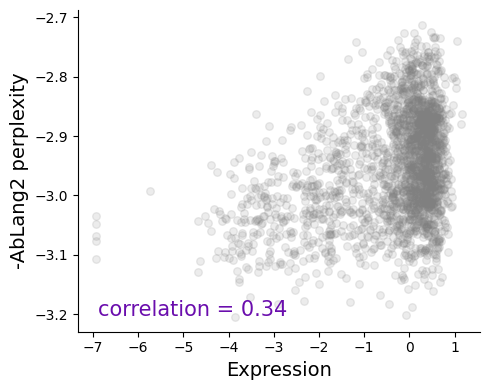

In [34]:
def plot_simple_correlation(expression_data, perplexity_data):
    """
    Creates a simple plot of Expression vs -AbLang2 perplexity for all mutations.
    
    Args:
        expression_data: DataFrame or array with expression values
        perplexity_data: DataFrame or array with perplexity values
        
    Returns:
        fig: The matplotlib figure
        ax: The axis object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import scipy.stats as stats
    
    # Create figure
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Convert inputs to numpy arrays if they aren't already
    if hasattr(expression_data, 'values'):
        x_values = expression_data.values.flatten()
    else:
        x_values = expression_data.flatten()
        
    if hasattr(perplexity_data, 'values'):
        y_values = -perplexity_data.values.flatten()
    else:
        y_values = -perplexity_data.flatten()
    
    # Remove NaN values
    mask = ~np.isnan(x_values) & ~np.isnan(y_values)
    x_filtered = x_values[mask]
    y_filtered = y_values[mask]
    
    # Randomize the order of points for better visualization
    if len(x_filtered) > 0:
        random_indices = np.random.permutation(len(x_filtered))
        x_filtered = x_filtered[random_indices]
        y_filtered = y_filtered[random_indices]
    
    # Calculate correlation
    corr = stats.pearsonr(x_filtered, y_filtered)[0]
    
    # Create scatter plot with gray points
    ax.scatter(x_filtered, y_filtered, alpha=0.15, s=30, color='gray')
    
    # Add correlation text
    ax.text(
        0.05,
        0.1,
        f"correlation = {corr:.2f}",
        transform=ax.transAxes,
        verticalalignment="top",
        fontsize=15,
        color="#6a0dad",
    )
    
    # Add axis labels
    ax.set_xlabel("Expression", fontsize=14)
    ax.set_ylabel("-AbLang2 perplexity", fontsize=14)
    
    # Remove spines
    sns.despine()
    
    # Apply tight layout
    fig.tight_layout()
    
    return fig, ax

# Example usage:
fig, ax = plot_simple_correlation(
    expr_dataset.heavy_dms_style_df,
    ablang_perplexity_heavy_df
)

# Save the figure
fig.savefig(f"{figures_dir}/expression_perplexity_correlation.svg", bbox_inches='tight')